# Project LHP
I have been running a facebook page for my high school students where they can send their confessions about our high school or anything. When they send our the confessions, as admins, we read through these confessions and then post to the facebook page if the confessions approriate. 

In my opinion, this process takes lots of time. Therefore, I want to integrate natural language processing technique to the system in order to help admins to see **how well readers will engage in our content**

This project is developed on Google Colab.

# Necessary package

In [ ]:
%reload_ext autoreload
%autoreload 2|
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [ ]:
import numpy as np
import pandas as pd
import torch
import re
from tqdm import tqdm

# Set up environment

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 

'Tesla T4'

# Preprocessing the data

## Input text

In [ ]:
import os

# Append different confessions to enhance the data base 
# Also add new column to each dataframe to indicate the source of it
# For the test-set - Test on the new confessions
# 
confessions_links = ["data/lhpconfessions_facebook_statuses.csv", "data/rmitvnconf_facebook_statuses.csv", 
                     "data/NthersConfessions_facebook_statuses.csv", "data/PtnkConfession_facebook_statuses.csv"]

confessions = pd.DataFrame()
pattern = "(\w+)_(\w+)_(\w+)"

for link in confessions_links:
  individual_confessions = pd.read_csv(link)
  individual_confessions["source"] = re.search(pattern, link).group(1)
  
  confessions["key"] = 1
  individual_confessions["key"] = 1
  
  temp = pd.merge(confessions, individual_confessions, how = "outer")
  confessions = temp.drop("key", axis = 1)
  

print(confessions[:5])
print("Amount of data %d" % len(confessions))

## Eliminate some corpus


In [ ]:
status_type = confessions["status_type"].unique()
status_type
keep = ["status", "note"]
confessions = confessions.loc[confessions["status_type"].isin(keep)]
confessions = confessions[pd.notnull(confessions["status_message"])]
print("There is %d corpus with valid message" % len(confessions))
confessions.head()

In [ ]:
# Eliminate corpus that only have like
confessions = confessions.loc[confessions["num_likes"] != confessions["num_reactions"]]
print("There is %d corpus with various reactions instead of likes" % len(confessions))
confessions.head()

In [ ]:
# Normalize all the reactions columns
import sklearn
from sklearn import preprocessing

normalize_all = False

reaction_status = ['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
transformations = preprocessing.MinMaxScaler()

if normalize_all:
  max_reactions = np.max(confessions.loc[:, reaction_status].max().values)
  min_reactions = np.min(confessions.loc[:, reaction_status].min().values)

  print(max_reactions)

  confessions["max_reactions"] = max_reactions
  confessions["min_reactions"] = min_reactions

else:
  confessions[reaction_status] = transformations.fit_transform(confessions[reaction_status].values)
  
  '''
    Encounter some bias to the model
  '''
  
#   means = confessions.loc[:, reaction_status].mean().values
  
confessions.head()
# Normalize different columns


In [ ]:
# Without pre-processing the content
confessions.to_csv(os.getcwd() + "/data/statuses_without_preprocess.csv", index = False)

##Cleaning the corpus

In [ ]:
# Undersea library
from underthesea import sent_tokenize, word_tokenize
import string

# Lowercase the text in the content
def lowerContent(content: str, isDebug: bool = False):
    if isDebug:
        print(">> The content with all lowercase:\n %s" % content.lower())
    return content.lower()

# Remove all the number
def removeNumber(content: str, isDebug: bool = False):
    content = re.sub(r"\d+", "", content)
    if isDebug:
        print(">> The content without any numbers:\n %s" % content)
    return content

# Remove all the punctuation
def removePunctuation(content: str, isDebug: bool = False):
  # content = content.replace(".", "[MASKDOTSIGN]")
  content = content.translate(str.maketrans("", "", string.punctuation))
  # content = content.replace("MASKDOTSIGN", ".")
  if isDebug:
      print(">> The content without any punctuation:\n %s" % content)
  return content

# Remove the white space
def removeWhiteSpace(content: str, isDebug: bool = False):
    content = content.strip()
    if isDebug:
        print(">> The content without any whitespace:\n %s" % content)
    return content

def singleSpace(content: str, isDebug: bool = False):
    content = ' '.join(content.split())
    if isDebug:
        print(">> The content with single space:\n %s" % content)
    return content

# Basic cleaning
def cleaningProcess(content: str):
  '''
    TODO: To do pre-train on the content with BERT, we want to keep the "." only so 
    I will change the "." to "MASKDOTSIGN" then after the preprocess, I will change 
    back to "."
  ''' 
  content = lowerContent(content)
  content = removeNumber(content)
  content = removePunctuation(content)
  content = removeWhiteSpace(content)
  content = singleSpace(content)
  return content

pre_process = []
for index, row in tqdm(confessions.iterrows(), total = len(confessions)):
  temp = cleaningProcess(row["status_message"])
  pre_process.append(cleaningProcess(row["status_message"]))
print("\n" + pre_process[0])
 

In [ ]:
# Save all the pre-processing content
confessions["status_message"] = pre_process
print("Amount of saving content %d" % len(confessions))
confessions.head()
print("The file saved in %s" % os.getcwd() + "/data/statuses_with_preprocess.csv")
confessions.to_csv(os.getcwd() + "/data/statuses_with_preprocess.csv", index = False)
confessions.head()

# Embed Fastai with BERT

In [ ]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-multilingual-cased",
    max_lr=3e-5,
    bs = 16,
   use_fp16=True,
    freeze_epochs=2,
    unfreeze_epochs=4,
    discriminative=False,
    max_seq_len=300,
)

In [61]:
from pytorch_pretrained_bert import BertTokenizer 
bert_tok = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.


In [ ]:
class FastAiBertTokenizer(BaseTokenizer): 
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs): 
      self._pretrained_tokenizer = tokenizer
      self.max_seq_len = max_seq_len 
           
    def __call__(self, *args, **kwargs): 
      return self 
    
    def tokenizer(self, t:str) -> List[str]:
      """Limits the maximum sequence length""" 
      return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [ ]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

# Regression Classifier with prediction reactions

In [83]:
from sklearn.model_selection import train_test_split
label_cols = ['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
dir_file = os.getcwd() + "/data/statuses_with_preprocess.csv"
confessions = pd.read_csv(dir_file)

def buildDataBunch():

  processor = [TokenizeProcessor(tokenizer = fastai_tokenizer, mark_fields=False, include_bos = False, include_eos=False),
              NumericalizeProcessor(vocab = fastai_bert_vocab, min_freq = 2)]
  train, val = train_test_split(confessions)
  val_idx = val.index


  databunch = (ItemLists(os.getcwd() + "/data/",
                TextList.from_df(train, os.getcwd() + "/data/", cols="status_message", processor = processor),
                TextList.from_df(val, os.getcwd() + "/data/", cols="status_message", processor = processor)
                ).label_from_df(cols = label_cols, label_cls=FloatList)
                .databunch(bs = config.bs, collate_fn=partial(pad_collate, pad_first=False, pad_idx=0)))
  return databunch

ClassificationDataBunch = buildDataBunch()
ClassificationDataBunch

TextClasDataBunch;

Train: LabelList (1458 items)
x: TextList
[CLS] n ##k ##c ##f là một học sinh trường ngoài có bạn của cả cơ sở c ##s với con mắt của người ngoài cuộc mình nhìn nhận vấn đề c ##s của các bạn như sau thứ nhất về chất lượng giảng dạy thì cũng có rất nhiều th ##ầy cô c ##s qua c ##s dạy đề kiểm tra cũng tương tự nên mình nói chất lượng giảng dạy là như nhau về chất lượng học sinh điểm đầu vào c ##s cao hơn c ##s nên chất lượng học sinh c ##s hơn c ##s và điều đó thể hiện qua số lượng học sinh gi ##ỏ ##i học sinh khá học sinh gi ##ỏ ##i c ##s vẫn tương đương học sinh gi ##ỏ ##i c ##s không khác gì cả về môi trường học tập c ##s t ##ụ tập những bạn rất gi ##ỏ ##i lại với nhau nên là một môi trường tốt để nâng cao tri thức nhưng còn về vui chơi giải trí với diện tích rộng cơ sở vật chất tốt c ##s rõ ràng ăn đ ##ứt c ##s với những sân ban ##h sân bóng r ##ổ chính nhờ c ##s mà các bạn mới có những buổi lửa trại th ##âu đêm những chuyến đi chơi thú vị ##th ##ế nên các bạn đ #

In [ ]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=len(label_cols))

# Fine-tune with BERT

I choose L1 Smooth because my data has a big variance between different reactions. Therefore, MSE will not work well with these kind of data

## Smooth absolute error loss

In [ ]:
# Intialize Fastai container with BERT model
loss_func = torch.nn.SmoothL1Loss()
learner_L1loss = Learner(ClassificationDataBunch, bert_model, loss_func = loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


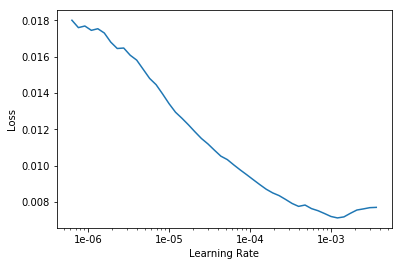

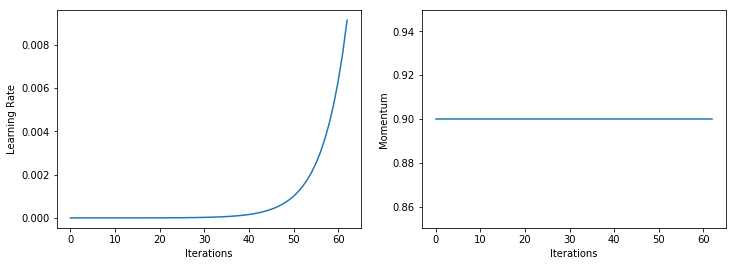

In [85]:
# Run the learning finder test
learner_L1loss.lr_find()
learner_L1loss.recorder.plot()
learner_L1loss.recorder.plot_lr(show_moms=True)

In [86]:
# Fine-tune the last layer first
config.max_lr = 1e-04
learner_L1loss.fit_one_cycle(config.freeze_epochs, max_lr = config.max_lr, moms=0.8)

epoch,train_loss,valid_loss,time
0,0.002231,0.000461,01:24
1,0.001146,0.000398,01:20


In [87]:
learner_L1loss.save("L1loss_fit_head", return_path = True)

PosixPath('/content/gdrive/My Drive/projectlhp/data/models/L1loss_fit_head.pth')

In [88]:
learner_L1loss.export("models/L1loss_fit_head.pkl")
path = learner_L1loss.path
path

PosixPath('/content/gdrive/My Drive/projectlhp/data')

In [89]:
# Fine-tune the last two layer
learner_L1loss.freeze_to(-2)
learner_L1loss.fit_one_cycle(1, max_lr = config.max_lr / 2)

epoch,train_loss,valid_loss,time
0,0.000959,0.000412,01:17


In [90]:
learner_L1loss.save("L1Loss_second_head", return_path = True)

PosixPath('/content/gdrive/My Drive/projectlhp/data/models/L1Loss_second_head.pth')

In [91]:
learner_L1loss.export("models/L1Loss_second_head.pkl")
path = learner_L1loss.path
path

PosixPath('/content/gdrive/My Drive/projectlhp/data')

In [92]:
# Fine-tune the whole model
learner_L1loss.unfreeze()
learner_L1loss.fit_one_cycle(config.unfreeze_epochs, max_lr = config.max_lr)

epoch,train_loss,valid_loss,time
0,0.001000,0.000757,01:18
1,0.000840,0.000452,01:08
2,0.000886,0.000409,01:21
3,0.000745,0.000398,01:12


In [93]:
learner_L1loss.save("L1Loss_final_model", return_path = True)

PosixPath('/content/gdrive/My Drive/projectlhp/data/models/L1Loss_final_model.pth')

In [94]:
learner_L1loss.export("models/L1Loss_final_model.pkl")
path = learner_L1loss.path
path

PosixPath('/content/gdrive/My Drive/projectlhp/data')

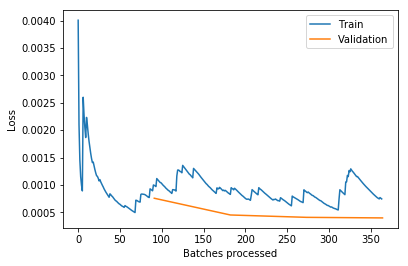

In [95]:
learner_L1loss.recorder.plot_losses()

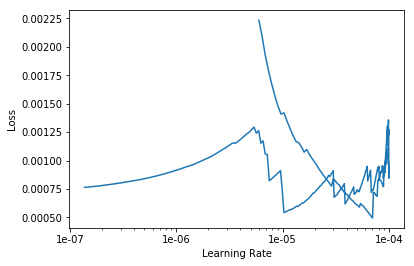

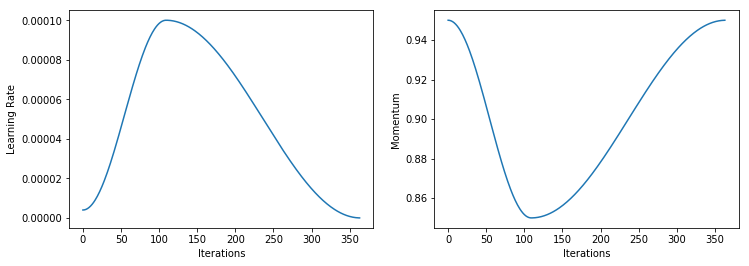

In [96]:
learner_L1loss.recorder.plot()
learner_L1loss.recorder.plot_lr(show_moms=True)

## Feedforward Neural Netword with BERT Emebedding

I observed that fine-tune like I did above takes long time for the model the converge and the generalization is not as good as I expect. Instead of fine-tuning the whole model of BERT, I can extract the feature of token [CLS] of each sentence in the last layer for classification purpose

## Necessary library

In [ ]:
# Import necessary packages
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as utils

import plotly.graph_objects as go

import math
import copy
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import matplotlib

## Extract features from BERT

In [67]:
# Adjust batch size
config.bs = 16
ClassificationDataBunch = buildDataBunch()
loss_func = torch.nn.SmoothL1Loss()
learner_L1loss = Learner(ClassificationDataBunch, bert_model, loss_func = loss_func)

# Extract the last layers of BERT
embedding_size, label_size = 768, 6
trainSet, validSet = None, None
dataLoader, validLoader = None, None
# for phase in ["valid", "train"]:
for phase in ["train", "valid"]:
  features, labels = [], []
  print("\n>> Extract features for %s set" % phase)
  dataset = learner_L1loss.data.train_dl
  numParagraph = 0
  if phase == "valid": dataset = learner_L1loss.data.valid_dl
  for index, batches in tqdm(enumerate(dataset), total = len(dataset)):
    X, y = [], []
    numParagraph += min(config.bs, batches[0].shape[0])
    for i in range(min(config.bs, batches[0].shape[0])):
      paragraphToken = batches[0][i]
      embedding_features = learner_L1loss.model.bert(paragraphToken.unsqueeze(0))[-1]
      output = batches[1][i]
      X.append(embedding_features.cpu())
      y.append(output.cpu())
      del embedding_features
      del output
      torch.cuda.empty_cache()

    ## Why this does not cause the overload memory
    X, y = torch.stack(X), torch.stack(y)
    X, y = Variable(X).cuda(), Variable(y).cuda()
    features.append(X)
    labels.append(y)

  torch.cuda.empty_cache()
  features, labels = torch.cat(features), torch.cat(labels)
  features, labels = features.resize_(numParagraph, embedding_size), labels.resize_(numParagraph, label_size)
  if phase == "train":
    trainSet = utils.TensorDataset(features.cpu(), labels.cpu())
    trainLoader = utils.DataLoader(trainSet, batch_size=config.bs, shuffle=True, num_workers=4)
  else:
    validSet = utils.TensorDataset(features.cpu(), labels.cpu())
    validLoader = utils.DataLoader(validSet, batch_size=config.bs, shuffle=True, num_workers=4)

  0%|          | 0/91 [00:00<?, ?it/s]


>> Extract features for train set


  0%|          | 0/31 [00:00<?, ?it/s]


>> Extract features for valid set


100%|██████████| 31/31 [00:19<00:00,  3.11it/s]


In [68]:
print(len(trainSet))

1456


In [69]:
len(trainLoader)

91

## Configuration of NN

In [ ]:
### Define the model
layer_features = [200, 100, 80]
embedding_size = 768

class FeedForwardNeuralNetwork(nn.Module):
  def __init__(self, layer_features: list, embedding_size: int, dropout_rate = 0.2):
    super(FeedForwardNeuralNetwork, self).__init__()
    self.fc1 = torch.nn.Linear(embedding_size, layer_features[0])
    self.fc2 = torch.nn.Linear(layer_features[0], layer_features[1])
    self.fc3 = torch.nn.Linear(layer_features[1], layer_features[2])
    self.fc4 = torch.nn.Linear(layer_features[2], label_size)
    self.activation = torch.nn.ReLU()
    self.lastLayer = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(dropout_rate)
  
  def forward(self, X: torch.autograd.Variable) -> torch.autograd.Variable:
    # out1 = self.dropout(self.activation(self.fc1(X)))
    # out2 = self.dropout(self.activation(self.fc2(out1)))
    out1 = self.activation(self.fc1(X))
    out2 = self.activation(self.fc2(out1))
    out3 = self.activation(self.fc3(out2))
    output = self.lastLayer(self.fc4(out3))
    return output

feedForwardNet = FeedForwardNeuralNetwork(layer_features, embedding_size)
feedForwardNet.cuda()

# Try different loss
loss_func = torch.nn.L1Loss()

epoches = 200
copyNet = copy.deepcopy(feedForwardNet)

## Learning finder

I used learning finder of Smith and the smooth curve method from fastai in order to plot this graph

91


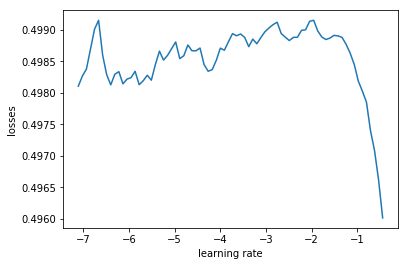

In [71]:
# Make a copy of the weight
feedForwardNet = copy.deepcopy(copyNet)

beta = 0.98
min_lr, max_lr = 1e-8, 1.
lr = min_lr
numTimes = len(trainLoader) - 1
constJump = (max_lr / min_lr) ** (1 / numTimes)
losses = []
log_lrs = []
avg_loss, best_loss, batch_num = 0., 0., 0.
optimizer = torch.optim.SGD(feedForwardNet.parameters(), lr = min_lr)

for data in trainLoader:
  batch_num += 1
  inputs, labels = data
  inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
  optimizer.zero_grad()
  predictions = feedForwardNet(inputs)
  loss = loss_func(predictions, labels)

  ## Smooth the curve
  avg_loss = beta * avg_loss + (1 - beta) * loss.cpu().item()
  smooth_loss = avg_loss / (1 - beta ** batch_num)
  if batch_num > 1 and smooth_loss > 4 * best_loss: break
  if smooth_loss < best_loss or batch_num == 1: best_loss = smooth_loss

  losses.append(smooth_loss)
  log_lrs.append(math.log10(lr))

  loss.backward()
  optimizer.step()
  
  lr *= constJump
  optimizer.param_groups[0]['lr'] = lr

print(len(log_lrs))
plt.plot(log_lrs[10:-5], losses[10:-5])
plt.xlabel("learning rate")
plt.ylabel("losses")
plt.show()

## Training process with dropout + early stop


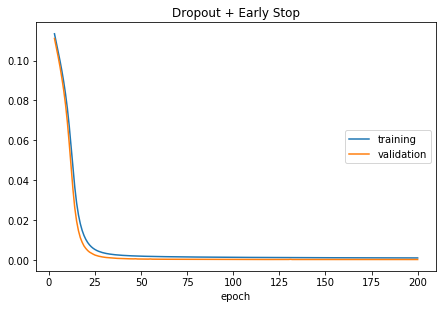

Dropout + Early Stop:
training   (min:    0.001, max:    0.123, cur:    0.001)
validation (min:    0.000, max:    0.121, cur:    0.000)


In [100]:
is_loaded = False
torch.manual_seed(1)    # reproducible

train_error, valid_error = [], []
stopped = False
# Plot real-time plot
liveloss = PlotLosses()

# Load the network
feedForwardNet = copy.deepcopy(copyNet)
optimizer = torch.optim.SGD(feedForwardNet.parameters(), lr=1e-2)

for step in range(epoches):
  logs = {}
  losses = {"train": 0., "valid": 0.}
  dataLoader = None
  for phase in ["train", "valid"]:
    if phase == "train": 
      feedForwardNet.train()
      dataLoader = trainLoader
    else:
      feedForwardNet.eval()
      dataLoader = validLoader

    for data in dataLoader:
      inputs, labels = data
      inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
      optimizer.zero_grad()
      predictions = feedForwardNet(inputs)
      loss = loss_func(predictions, labels)
      losses[phase] += loss
      loss.backward()
      optimizer.step()
      
    if phase != "valid": 
      train_error.append(losses["train"] / len(trainLoader))
      logs["Dropout + Early Stop"] = losses["train"] / len(trainLoader)
    else: 
      valid_error.append(losses["valid"] / len(validLoader))
      logs["val_" + "Dropout + Early Stop"] = losses["valid"] / len(validLoader)
      break
    # Adding early stop
    if step > 5 and phase == "valid":
      # If last 5 steps the validation error increases then stop
      smaller = False
      for i in range(step, step - 4, -1):
        if valid_error[i] < valid_error[i + 1]: 
          smaller = True
          break
      if smaller: 
        stopped = True
        break
  if stopped: 
    print(">> Early stop at step %d" % step)
    break
  liveloss.update(logs)
  liveloss.draw()

In [ ]:
feedForwardNet.eval()
save_dir = os.getcwd() + "/data/models/drop_early.path"
torch.save(feedForwardNet.state_dict(), save_dir)

## Training with cycle learning rate and dropout

100%|██████████| 32/32 [00:41<00:00,  1.32s/it]


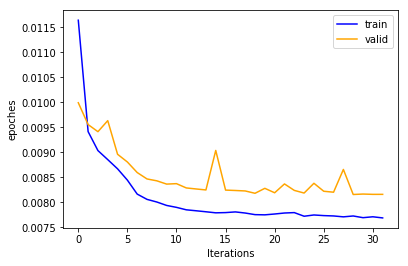

In [ ]:
from IPython.display import clear_output

feedForwardNet = copy.deepcopy(copyNet)

num_cycle = 8
epoch = len(trainLoader) # epoch = numOfData / batch_size
stepSize = 2 * epoch # Half of the cycle
# Total iteration = stepSize * 2 * num_cycle 
#       => we only need to go through num_cycle * 4 times of the trainLoader in 
#          order get the total interations

# Set up learning rate
base_lr, max_lr = 3e-1, 9e-1
optimizer = torch.optim.SGD(feedForwardNet.parameters(), lr = base_lr, momentum = 0.85)
trainLoss, validLoss, epoch_plot = [], [], []
lr_plot, iter_plot = [], []
epochCounter = 0

for iteration in tqdm(range(num_cycle * 4)):
  for batch, data in enumerate(trainLoader):
    inputs, labels = data
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)    

    predictions = feedForwardNet(inputs)
    loss = loss_func(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epochCounter = iteration * epoch + batch
    cycle = math.floor(1 + epochCounter / (2 * stepSize))
    x = abs(epochCounter / stepSize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    optimizer = torch.optim.SGD(feedForwardNet.parameters(), lr = lr, momentum = 0.85)

  trainLoss.append(evalModel(feedForwardNet, trainLoader))
  validLoss.append(evalModel(feedForwardNet, validLoader))
  epoch_plot.append(iteration)

plt.plot(epoch_plot, trainLoss, "blue")
plt.plot(epoch_plot, validLoss, "orange")
plt.legend(("train", "valid"), loc='upper right')
plt.xlabel("Iterations")
plt.ylabel("epoches")
plt.show()

In [ ]:
# Run the validation set
def evalModel(model: FeedForwardNeuralNetwork, validLoader: dataLoader) -> float:
  model.eval()
  validLoss = 0
  for data in validLoader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    predictions = model(inputs)
    loss = loss_func(predictions, labels)
    validLoss += loss.item()
  return validLoss / len(validLoader)

In [ ]:
feedForwardNet.eval()
save_dir = os.getcwd() + "/data/models/cycle_learning.path"
torch.save(feedForwardNet.state_dict(), save_dir)

# Evaluate the model

In [ ]:
# Fastai with BERT model
ClassificationDataBunch = buildDataBunch()
loss_func = torch.nn.SmoothL1Loss()
fastai_bert = Learner(ClassificationDataBunch, bert_model, loss_func = loss_func)
fastai_bert = fastai_bert.load("/content/gdrive/My Drive/projectlhp/data/models/L1Loss_final_model")

In [120]:
# Evaluate all three model

# Get a paragraph from the dataset
dataset = fastai_bert.data.valid_dl
batch = np.random.randint(len(dataset), size=1)[0]
paragraph, fastai_bert_pred, embedding_features, ground_truth = "", None, None, None
for index, batches in enumerate(dataset):
  if index == batch:
    idx = np.random.randint(batches[0].shape[0], size=1)[0]
    ground_truth = batches[1][idx]
    fastai_bert_pred = fastai_bert.model(batches[0][idx].unsqueeze(0))
    inputId = batches[0][idx].cpu()
    paragraph = " ".join(fastai_bert.data.train_dl.vocab.textify(inputId).split(' '))
    embedding_features = fastai_bert.model.bert(inputId.unsqueeze(0).to(device))[-1]

print(paragraph, "\n")
embedding_features = embedding_features.reshape(768)
# Neural Network with dropout + early stop
model_dropout = FeedForwardNeuralNetwork(layer_features, embedding_size)
model_dropout.load_state_dict(torch.load(os.getcwd() + "/data/models/drop_early.path"))
model_dropout.eval()
model_dropout_pred = model_dropout(embedding_features.cpu())

# Neural Network with cycal learning
model_cycle = FeedForwardNeuralNetwork(layer_features, embedding_size)
model_cycle.load_state_dict(torch.load(os.getcwd() + "/data/models/cycle_learning.path"))
model_cycle.eval()
model_cycle_pred = model_cycle(embedding_features.cpu())

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Show the result
print("The ground truth of the confession")
print(ground_truth.cpu().detach().numpy(), "\n\n")

print("The prediction of fastai_bert")
print(fastai_bert_pred.squeeze(0).cpu().detach().numpy(), loss_func(ground_truth.squeeze(0), fastai_bert_pred).item(), "\n\n")

print("The prediction of dropout + early stop")
print(model_dropout_pred.detach().numpy(), loss_func(ground_truth.squeeze(0), model_dropout_pred.to(device)).item(), "\n\n")

print("The prediction of cycle learning + dropout")
print(model_cycle_pred.detach().numpy(), loss_func(ground_truth.squeeze(0), model_cycle_pred.to(device)).item(), "\n\n")

[unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [unused1] [CLS] hoạt động ý nghĩa cho ngày hè thêm vui bạn yêu chó m ##èo bạn thích trẻ con bạn mon ##g muốn có một mùa hè ý nghĩa được tham gia những hoạt động xã hội để có thêm kinh nghiệm và giúp í ##ch cho cộng đồng bạn nghĩ sao nếu có một mộ ##i trường cho phép bạn chơi đ ##ùa th ##o ##ải má ##i với các em nhỏ các bé chó m ##èo và cùng nhau th ##ỏa sức sáng tạo trong một môi trường thân thiện gần g ##ũ ##i và an toàn the seeds project là một dự án vừa được thành lập với mon ##g muốn đem đến cho các em nhỏ các bạn trẻ những kiến thức về ph ##úc lợi động vật hiện tại dự án đang cần tuyển b ##t ##c ở các ban truyền thông ph ##úc lợi hậu cần và thiết kế bên cạnh ni ##ềm vui khi được làm điều mình thích khi tham gia the seeds project bạn sẽ có thêm nhiều cơ hội để r ##èn luyện các k ##ĩ năng làm việc nhóm quản lý cũng như phát triển những khả năng nhất định 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:804: UserWarning:

Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

